In [3]:
# ==========================================================
# BLOCCO 1 ✅ DEFINITIVO
# Lettura dataset compressi + Preprocessing etichette
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("📂 Caricamento dataset compressi...")

# === Lettura file .npz generato nel BLOCCO 11 ===
data_npz = np.load(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_bal.npz", allow_pickle=True)

# === Estrazione dei dataset ===
X_train = data_npz["X_train"]
X_test = data_npz["X_test"]
y_train = data_npz["y_train"]
y_test = data_npz["y_test"]

# === Dataset bilanciato opzionale ===
X_train_bal = data_npz["X_train_bal"]
y_train_bal = data_npz["y_train_bal"]

print("✅ Dataset caricati con successo dal file .npz\n")

# === Conversione etichette (da stringhe a numeri) ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_bal_enc = le.transform(y_train_bal)

# === Info riepilogative ===
print("📊 Dimensioni:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}  | y_test : {y_test.shape}")
print(f"X_train_bal: {X_train_bal.shape} | y_train_bal: {y_train_bal.shape}")

print("\n🔢 Classi trovate:", list(le.classes_))
print("Numero classi:", len(le.classes_))

# === Verifica che tutto sia numerico ===
X_train_used = X_train_bal if X_train_bal is not None else X_train
print("\nTipi delle colonne in X_train_used:")
print(pd.DataFrame(X_train_used).dtypes.value_counts())

non_numeric = [
    col for col in pd.DataFrame(X_train_used).columns
    if not np.issubdtype(pd.DataFrame(X_train_used)[col].dtype, np.number)
]
print("\nColonne non numeriche:", non_numeric)

📂 Caricamento dataset compressi...
✅ Dataset caricati con successo dal file .npz

📊 Dimensioni:
X_train: (245672, 16) | y_train: (245672,)
X_test : (61418, 16)  | y_test : (61418,)
X_train_bal: (38448, 16) | y_train_bal: (38448,)

🔢 Classi trovate: ['Discovery', 'Reconnaissance', 'Resource Development']
Numero classi: 3

Tipi delle colonne in X_train_used:
float32    16
Name: count, dtype: int64

Colonne non numeriche: []


In [20]:
# ==========================================================
# BLOCCO 2 ✅ Random Forest (train bilanciato) con monitoraggio fold per fold e griglia estesa
# ==========================================================
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize

print("🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...\n")

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # più alberi per stabilità

param_grid = {
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni (~{len(param_combinations)*5} fit fold per fold)...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = -np.inf
best_params = None
results = []

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (max_depth, min_split, min_leaf, max_feat, boot) in enumerate(param_combinations, 1):
    params = {
        'max_depth': max_depth,
        'min_samples_split': min_split,
        'min_samples_leaf': min_leaf,
        'max_features': max_feat,
        'bootstrap': boot
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal), 1):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            **params
        )
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    **best_params
)
best_rf.fit(X_train_bal, y_train_bal)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_rf.predict(X_train_bal)
y_test_pred = best_rf.predict(X_test)

# Convertiamo tutte le etichette in stringhe per evitare il ValueError
y_train_bal_str = y_train_bal.astype(str)
y_test_str = y_test.astype(str)
classes_str = np.unique(np.concatenate([y_train_bal_str, y_test_str]))

train_f1 = print_metrics(y_train_bal_str, y_train_pred.astype(str), "TRAIN", classes_str)
test_f1 = print_metrics(y_test_str, y_test_pred.astype(str), "TEST", classes_str)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...

🔍 Inizio GridSearch manuale su 32 combinazioni (~160 fit fold per fold)...

⚙️ Combinazione 1/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9993
   📈 Fold 2/5 → F1 = 0.9996
   📈 Fold 3/5 → F1 = 0.9999
   📈 Fold 4/5 → F1 = 0.9993
   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 1 completata in 9.74s | F1 medio = 0.9996

⚙️ Combinazione 2/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
   📈 Fold 1/5 → F1 = 0.9996
   📈 Fold 2/5 → F1 = 0.9997
   📈 Fold 3/5 → F1 = 1.0000
   📈 Fold 4/5 → F1 = 0.9993
   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 2 completata in 13.87s | F1 medio = 0.9997

⚙️ Combinazione 3/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9993
   

📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...

🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.
- Una curva *train alta e test bassa* indica **overfitting** (il modello impara troppo bene i dati di training).
- Curve vicine e stabili indicano **buona generalizzazione**.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


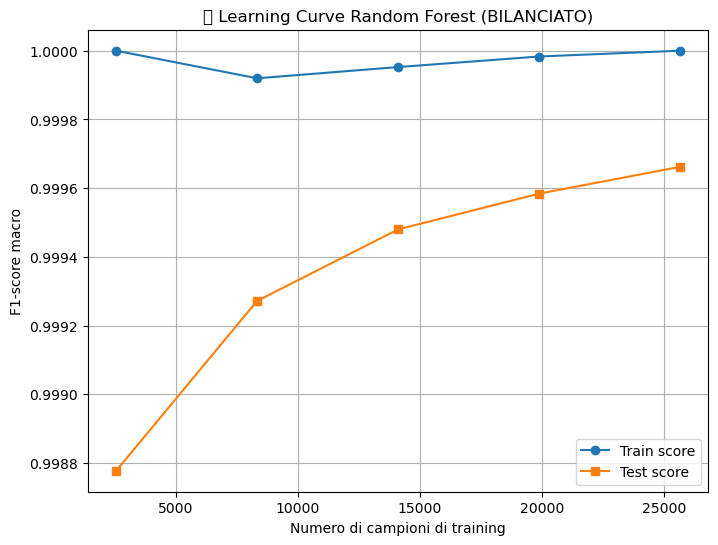


📊 **Confusion Matrix**: mostra come il modello classifica ciascuna classe.
- La diagonale principale indica le previsioni corrette.
- Valori fuori diagonale indicano errori di classificazione.
- Se è normalizzata, i valori sono percentuali di correttezza per classe.



<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


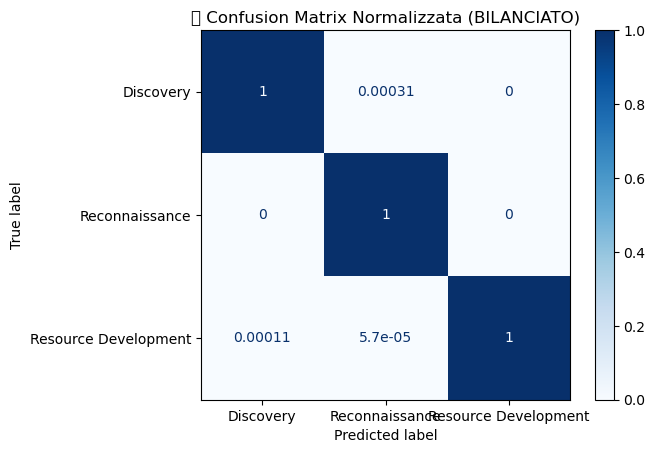


🎯 **Precision-Recall Curve (PR Curve)**:
- La precisione (asse Y) indica quante previsioni positive sono corrette.
- Il recall (asse X) indica quante istanze positive sono state trovate.
- Curve più in alto e più a destra → migliore capacità del modello di distinguere le classi.
- L’area sotto la curva (AP) riassume le prestazioni complessive.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


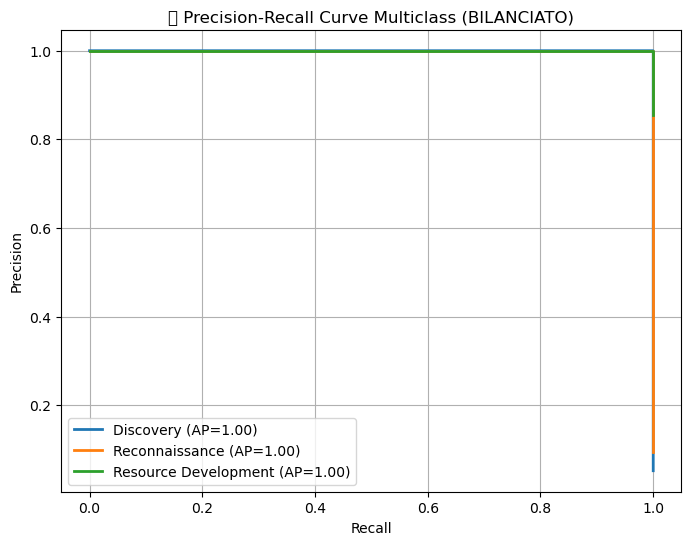


📈 **ROC Curve (Receiver Operating Characteristic)**:
- Mostra il compromesso tra *True Positive Rate* (sensibilità) e *False Positive Rate*.
- Curve più vicine al vertice superiore sinistro indicano prestazioni migliori.
- L’area sotto la curva (AUC) misura la qualità del modello: più è vicina a 1, meglio distingue le classi.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


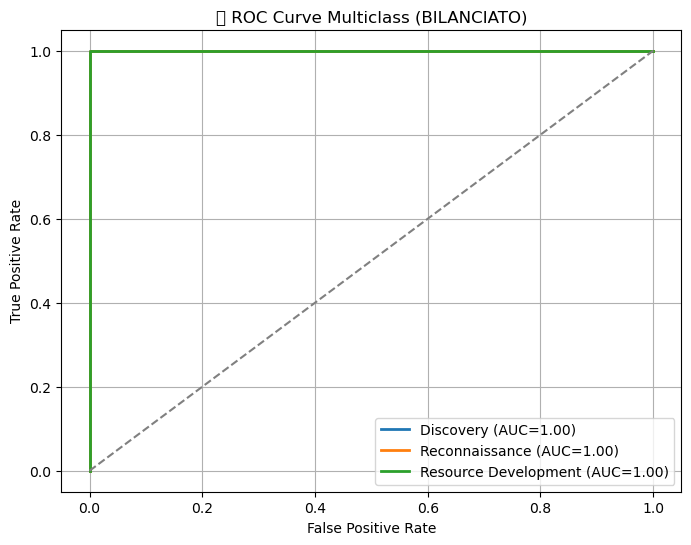


🌟 **Feature Importance**:
- Mostra quanto ciascuna variabile (latent feature) contribuisce alla decisione del modello.
- Valori più alti → feature più rilevanti.
- Utile per identificare le dimensioni latenti che influenzano maggiormente le predizioni.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


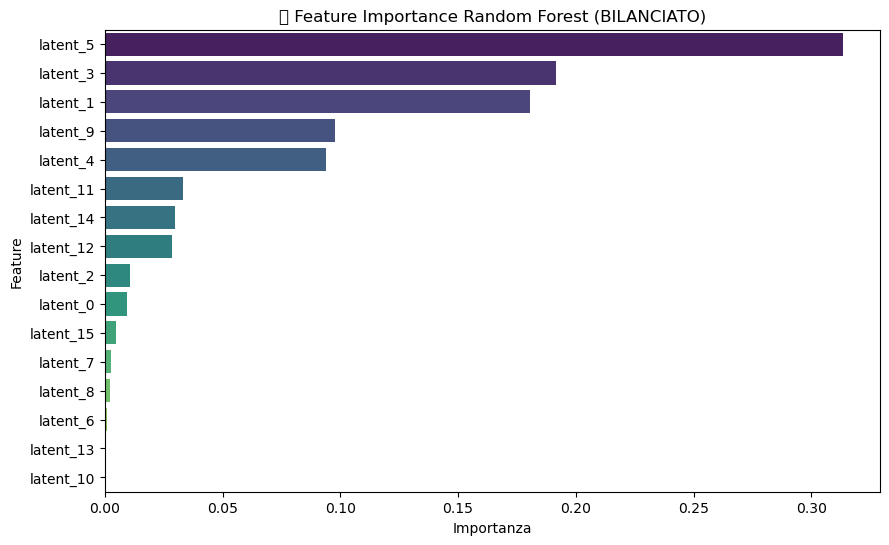


✅ Tutti i grafici e metriche avanzate generati con successo!


In [5]:
# ==========================================================
# BLOCCO 2b ✅ Metriche avanzate, grafici e interpretazione Random Forest
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

print("📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
print("🧩 **Learning Curve**: mostra come varia la prestazione del modello al crescere del numero di campioni di training.\n"
      "- Una curva *train alta e test bassa* indica **overfitting** (il modello impara troppo bene i dati di training).\n"
      "- Curve vicine e stabili indicano **buona generalizzazione**.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train_bal, y_train_bal_str, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve Random Forest (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
print("\n📊 **Confusion Matrix**: mostra come il modello classifica ciascuna classe.\n"
      "- La diagonale principale indica le previsioni corrette.\n"
      "- Valori fuori diagonale indicano errori di classificazione.\n"
      "- Se è normalizzata, i valori sono percentuali di correttezza per classe.\n")

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test_str, cmap='Blues', normalize='true'
)
plt.title("📊 Confusion Matrix Normalizzata (BILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision-Recall Curve multiclass
# ==========================================================
print("\n🎯 **Precision-Recall Curve (PR Curve)**:\n"
      "- La precisione (asse Y) indica quante previsioni positive sono corrette.\n"
      "- Il recall (asse X) indica quante istanze positive sono state trovate.\n"
      "- Curve più in alto e più a destra → migliore capacità del modello di distinguere le classi.\n"
      "- L’area sotto la curva (AP) riassume le prestazioni complessive.\n")

y_test_bin = label_binarize(y_test_str, classes=classes_str)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve multiclass
# ==========================================================
print("\n📈 **ROC Curve (Receiver Operating Characteristic)**:\n"
      "- Mostra il compromesso tra *True Positive Rate* (sensibilità) e *False Positive Rate*.\n"
      "- Curve più vicine al vertice superiore sinistro indicano prestazioni migliori.\n"
      "- L’area sotto la curva (AUC) misura la qualità del modello: più è vicina a 1, meglio distingue le classi.\n")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance
# ==========================================================
print("\n🌟 **Feature Importance**:\n"
      "- Mostra quanto ciascuna variabile (latent feature) contribuisce alla decisione del modello.\n"
      "- Valori più alti → feature più rilevanti.\n"
      "- Utile per identificare le dimensioni latenti che influenzano maggiormente le predizioni.\n")

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Random Forest (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici e metriche avanzate generati con successo!")


In [6]:
# ==========================================================
# BLOCCO 3 ✅ LightGBM (train bilanciato) con monitoraggio fold per fold
# versione pulita: usa DataFrame con nomi di feature coerenti
# ==========================================================
import numpy as np
import time
import pandas as pd
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

import lightgbm as lgb

print("🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con log pulito...\n")

# ==========================================================
# 0️⃣ Creazione DataFrame con nomi di feature coerenti
# ==========================================================
feature_names = [f'latent_{i}' for i in range(X_train_bal.shape[1])]
X_train_bal_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [10, -1],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100]
}

param_combinations = list(product(
    param_grid['num_leaves'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['n_estimators']
))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni...\n")

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (num_leaves, max_depth, lr, n_est) in enumerate(param_combinations, 1):
    params = {
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'learning_rate': lr,
        'n_estimators': n_est,
        'random_state': 42,
        'verbose': -1  # disattiva warning LightGBM
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal_df, y_train_bal), 1):
        X_tr, X_val = X_train_bal_df.iloc[train_idx], X_train_bal_df.iloc[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_lgb = lgb.LGBMClassifier(**best_params)
best_lgb.fit(X_train_bal_df, y_train_bal)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_lgb.predict(X_train_bal_df)
y_test_pred = best_lgb.predict(X_test_df)

train_f1 = print_metrics(y_train_bal, y_train_pred, "TRAIN", best_lgb.classes_)
test_f1 = print_metrics(y_test, y_test_pred, "TEST", best_lgb.classes_)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con log pulito...

🔍 Inizio GridSearch manuale su 16 combinazioni...

⚙️ Combinazione 1/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 50, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9993
   📈 Fold 2/5 → F1 = 0.9993
   📈 Fold 3/5 → F1 = 0.9996
   📈 Fold 4/5 → F1 = 0.9990
   📈 Fold 5/5 → F1 = 0.9995
✅ Combinazione 1 completata in 8.96s | F1 medio = 0.9993

⚙️ Combinazione 2/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 0.9997
   📈 Fold 3/5 → F1 = 0.9999
   📈 Fold 4/5 → F1 = 0.9996
   📈 Fold 5/5 → F1 = 0.9997
✅ Combinazione 2 completata in 11.35s | F1 medio = 0.9997

⚙️ Combinazione 3/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42, 'verbose': -1}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 0.9997
   📈 Fold 3/5 → F1 = 

🧩 Learning Curve (Curva di Apprendimento):
- Mostra come le prestazioni del modello cambiano al crescere del numero di campioni di training.
- Divario elevato tra training e test → possibile overfitting.
- Curve simili e alte → buona generalizzazione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


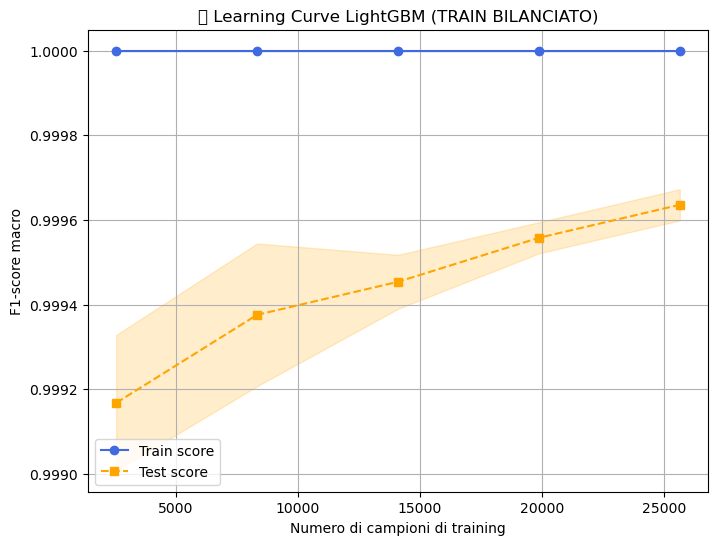


🌟 Feature Importance (Importanza delle Caratteristiche):
- Mostra quali latent features hanno maggiore impatto sulla predizione.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


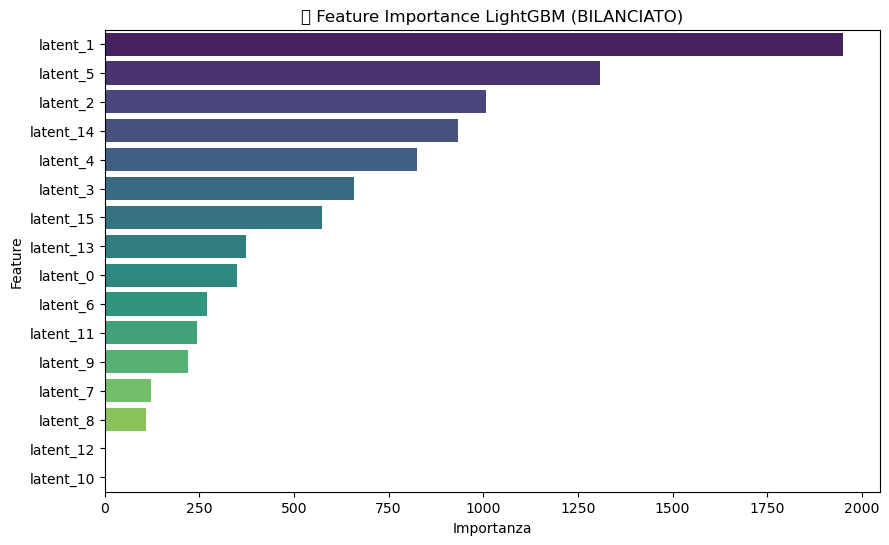

In [7]:
# ==========================================================
# 6️⃣ Learning Curve LightGBM
# ==========================================================
print("🧩 Learning Curve (Curva di Apprendimento):\n"
      "- Mostra come le prestazioni del modello cambiano al crescere del numero di campioni di training.\n"
      "- Divario elevato tra training e test → possibile overfitting.\n"
      "- Curve simili e alte → buona generalizzazione.\n")

train_sizes, train_scores, test_scores = learning_curve(
    best_lgb, 
    X_train_bal_df,  # usa il DataFrame con nomi coerenti
    y_train_bal,     # label in stringhe
    cv=3, 
    scoring='f1_macro', 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score", color='royalblue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='royalblue')
plt.plot(train_sizes, test_mean, 's--', label="Test score", color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve LightGBM (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 🔟 Feature Importance
# ==========================================================
print("\n🌟 Feature Importance (Importanza delle Caratteristiche):\n"
      "- Mostra quali latent features hanno maggiore impatto sulla predizione.\n")

importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance LightGBM (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()


In [8]:
# ==========================================================
# 🏗️ XGBoost (TRAIN BILANCIATO) con log pulito e fold-per-fold
# Versione coerente con LightGBM
# ==========================================================
import numpy as np
import pandas as pd
import time
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb

print("🏗️ Addestramento XGBoost (TRAIN BILANCIATO) con log pulito...\n")

# ==========================================================
# 0️⃣ DataFrame feature names coerenti
# ==========================================================
feature_names = [f'latent_{i}' for i in range(X_train_bal.shape[1])]
X_train_bal_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ==========================================================
# 1️⃣ Griglia iperparametri
# (simile complessità alla LightGBM)
# ==========================================================
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [100, 200]
}

param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['n_estimators']
))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni...\n")

# ==========================================================
# 2️⃣ Ciclo combinazioni con monitoraggio fold-per-fold
# ==========================================================
for i, (max_d, lr, subs, cols, n_est) in enumerate(param_combinations, 1):

    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'max_depth': max_d,
        'learning_rate': lr,
        'subsample': subs,
        'colsample_bytree': cols,
        'n_estimators': n_est,
        'seed': 42,
        'eval_metric': 'mlogloss'
    }

    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal_df, y_train_bal_enc), 1):
        X_tr, X_val = X_train_bal_df.iloc[train_idx], X_train_bal_df.iloc[val_idx]
        y_tr, y_val = y_train_bal_enc[train_idx], y_train_bal_enc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, verbose=False)
        y_pred = model.predict(X_val)

        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale
# ==========================================================
best_xgb = xgb.XGBClassifier(**best_params)
best_xgb.fit(X_train_bal_df, y_train_bal_enc)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_xgb.predict(X_train_bal_df)
y_test_pred = best_xgb.predict(X_test_df)

train_f1 = print_metrics(y_train_bal_enc, y_train_pred, "TRAIN", best_xgb.classes_)
test_f1  = print_metrics(y_test_enc, y_test_pred, "TEST", best_xgb.classes_)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento XGBoost (TRAIN BILANCIATO) con log pulito...

🔍 Inizio GridSearch manuale su 32 combinazioni...

⚙️ Combinazione 1/32 → {'objective': 'multi:softmax', 'num_class': 3, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.7, 'n_estimators': 100, 'seed': 42, 'eval_metric': 'mlogloss'}
   📈 Fold 1/5 → F1 = 0.9990
   📈 Fold 2/5 → F1 = 0.9993
   📈 Fold 3/5 → F1 = 0.9993
   📈 Fold 4/5 → F1 = 0.9988
   📈 Fold 5/5 → F1 = 0.9988
✅ Combinazione 1 completata in 9.22s | F1 medio = 0.9991

⚙️ Combinazione 2/32 → {'objective': 'multi:softmax', 'num_class': 3, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.7, 'n_estimators': 200, 'seed': 42, 'eval_metric': 'mlogloss'}
   📈 Fold 1/5 → F1 = 0.9996
   📈 Fold 2/5 → F1 = 0.9996
   📈 Fold 3/5 → F1 = 0.9997
   📈 Fold 4/5 → F1 = 0.9992
   📈 Fold 5/5 → F1 = 0.9993
✅ Combinazione 2 completata in 17.21s | F1 medio = 0.9995

⚙️ Combinazione 3/32 → {'objective': 'multi:softmax', 'num_class'

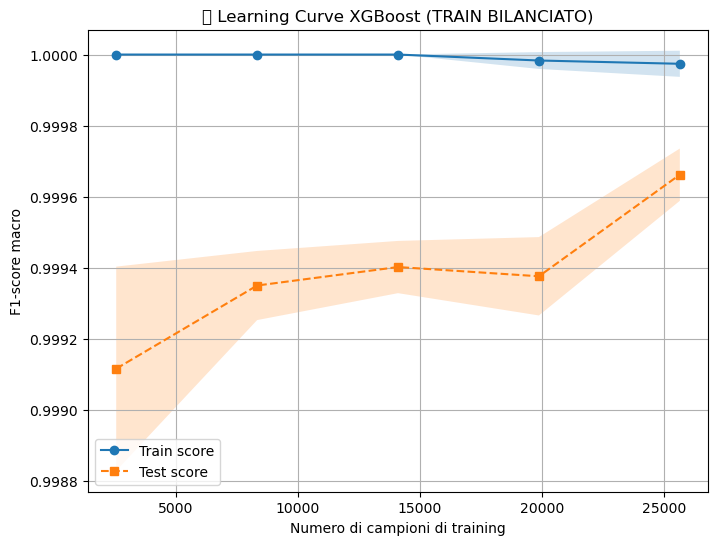

<Figure size 800x600 with 0 Axes>

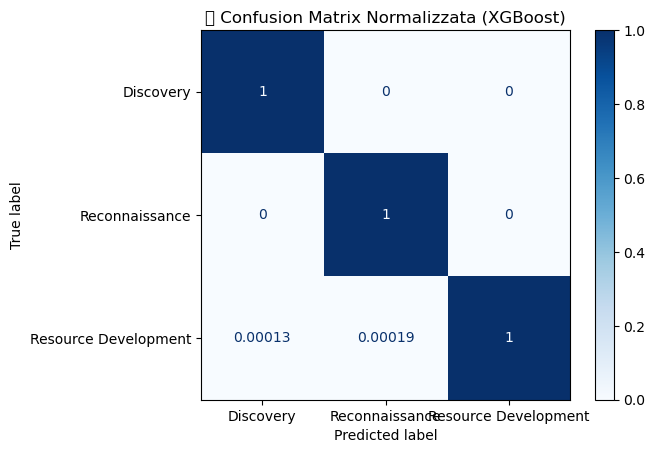

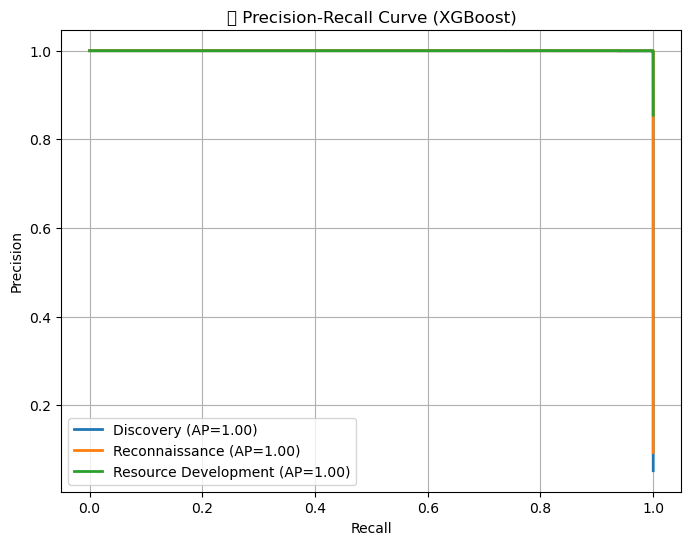

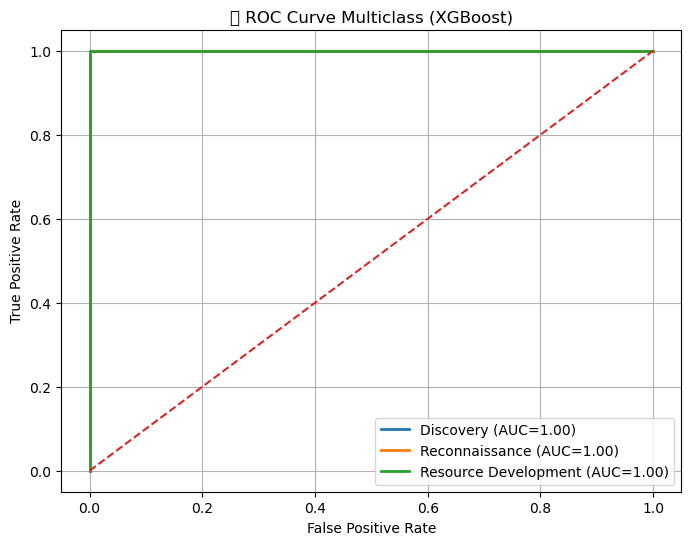

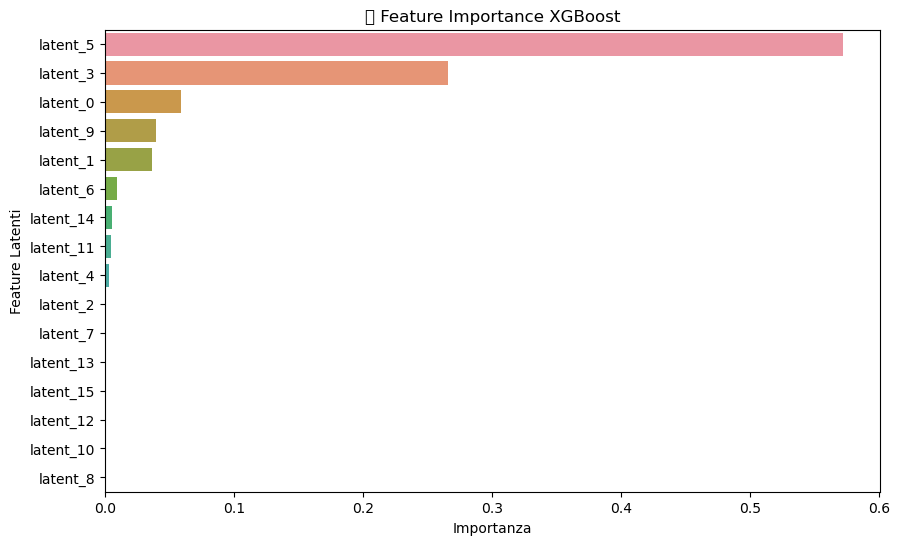


✅ Addestramento e grafici XGBoost completati con successo!


In [9]:
# ==========================================================
# 5️⃣ Learning Curve (coerente con XGBoost sopra)
# ==========================================================
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

# Copia parametri migliori e aggiorna objective per PR/ROC
lc_params = best_params.copy()
lc_params["objective"] = "multi:softprob"  # softprob per curve ROC/PR corrette
lc_params["eval_metric"] = "mlogloss"

model_xgb_clf = xgb.XGBClassifier(**lc_params)
model_xgb_clf.fit(X_train_bal_df, y_train_bal_enc)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_xgb_clf,
    X=X_train_bal_df,
    y=y_train_bal_enc,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_std   = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 's--', label="Test score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve XGBoost (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 6️⃣ Confusion Matrix, PR, ROC e Feature Importance
# ==========================================================
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize

class_labels = best_xgb.classes_
class_names  = ['Discovery', 'Reconnaissance', 'Resource Development']

# ✅ Confusion Matrix
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    model_xgb_clf,
    X_test_df,
    y_test_enc,
    cmap='Blues',
    normalize='true',
    display_labels=class_names
)
plt.title("📊 Confusion Matrix Normalizzata (XGBoost)")
plt.show()

# ✅ Precision-Recall Curve
y_test_bin = label_binarize(y_test_enc, classes=class_labels)
y_score = model_xgb_clf.predict_proba(X_test_df)

plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls_name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ ROC Curve
plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls_name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Feature Importance
importances = model_xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices]
)
plt.title("🌟 Feature Importance XGBoost")
plt.xlabel("Importanza")
plt.ylabel("Feature Latenti")
plt.show()

print("\n✅ Addestramento e grafici XGBoost completati con successo!")


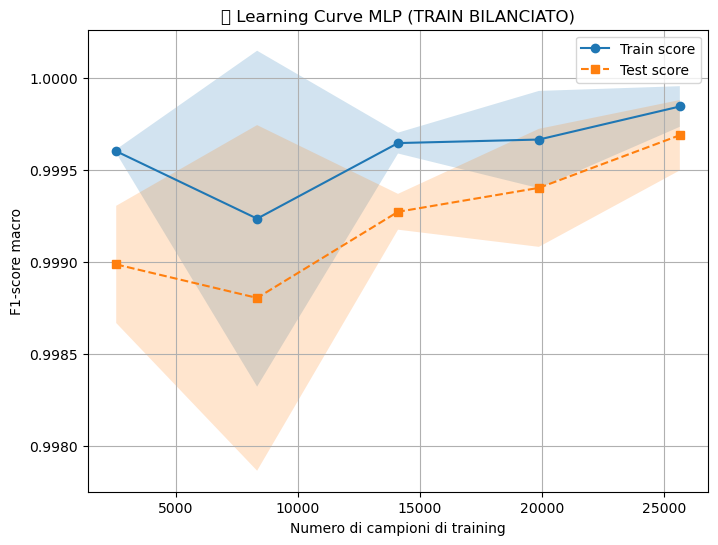

<Figure size 800x600 with 0 Axes>

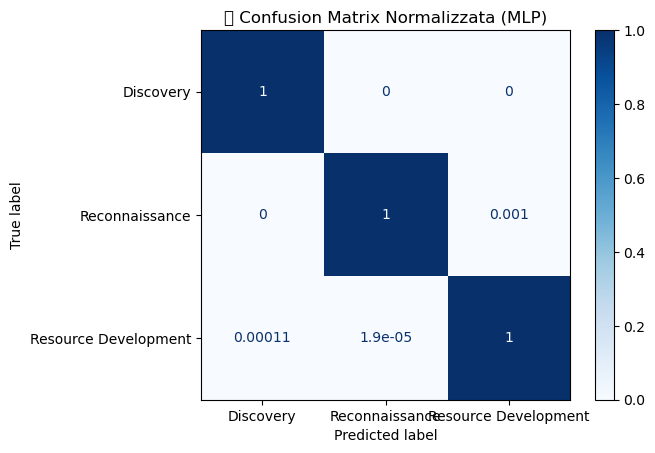

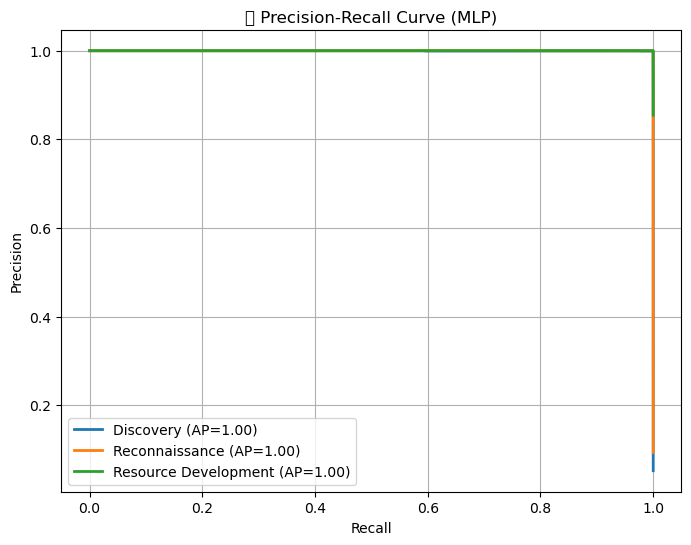

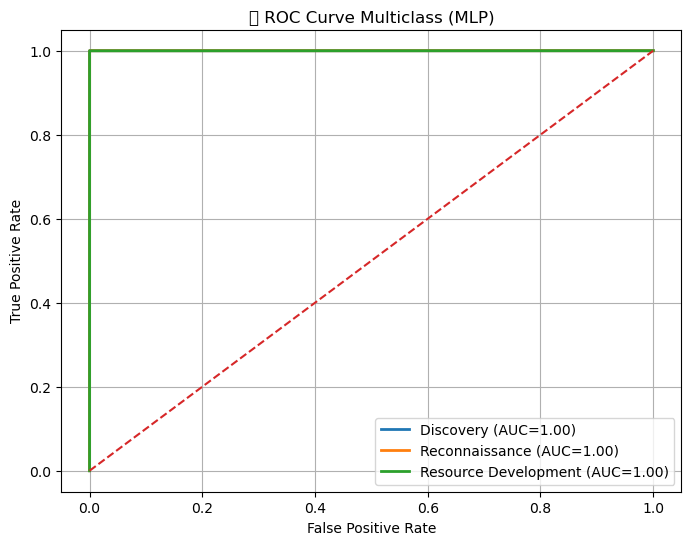

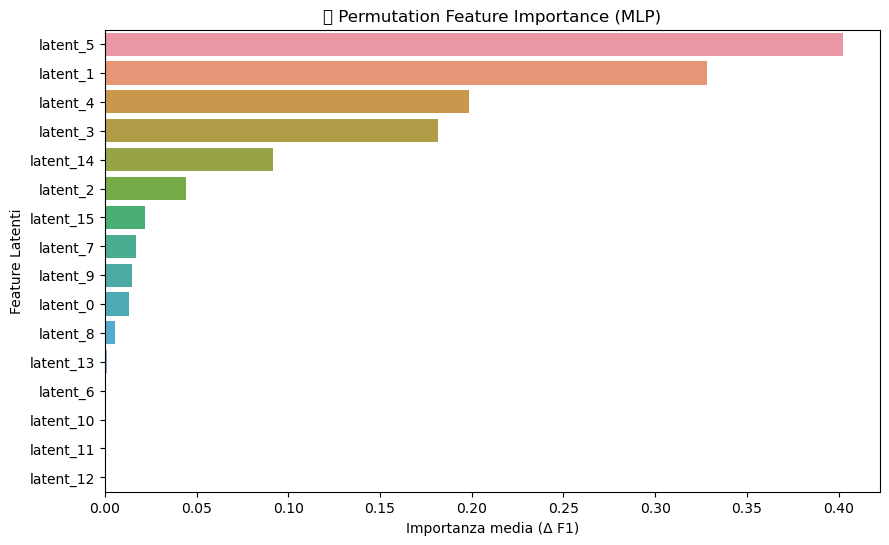


✅ Learning curve, curve e importance MLP generate correttamente!


In [27]:
# ==========================================================
# 5️⃣ Learning Curve MLP
# ==========================================================
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_mlp,
    X=X_train_scaled,
    y=y_train_bal_enc,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_std   = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, 's--', label="Test score")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve MLP (TRAIN BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 6️⃣ Confusion Matrix, PR, ROC e Feature Importance
# ==========================================================
class_labels = np.unique(y_train_bal_enc)
class_names  = ['Discovery', 'Reconnaissance', 'Resource Development']

# ✅ Confusion Matrix
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_mlp,
    X_test_scaled,
    y_test_enc,
    cmap='Blues',
    normalize='true',
    display_labels=class_names
)
plt.title("📊 Confusion Matrix Normalizzata (MLP)")
plt.show()

# ✅ Precision-Recall Curve
y_test_bin = label_binarize(y_test_enc, classes=class_labels)
y_score = best_mlp.predict_proba(X_test_scaled)

plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls_name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve (MLP)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ ROC Curve
plt.figure(figsize=(8,6))
for i, cls_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls_name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (MLP)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Permutation Feature Importance (equivalente per MLP)
perm = permutation_importance(best_mlp, X_test_scaled, y_test_enc, scoring='f1_macro', n_repeats=10, random_state=42)
perm_means = perm.importances_mean
indices = np.argsort(perm_means)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=perm_means[indices],
    y=[f'latent_{i}' for i in indices]
)
plt.title("🌟 Permutation Feature Importance (MLP)")
plt.xlabel("Importanza media (Δ F1)")
plt.ylabel("Feature Latenti")
plt.show()

print("\n✅ Learning curve, curve e importance MLP generate correttamente!")


In [29]:
# ==========================================================
# ✅ Confronto Modelli: Metriche & Feature Importance
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score
)

print("\n📊 Generazione report comparativo finale modelli...\n")

# ----------------------------------------------------------
# 🔧 Funzione predizione per MLP (gestisce prob o classi)
# ----------------------------------------------------------
def predict_mlp(model, X):
    y_pred = model.predict(X)

    # Se output è 1D → sono già etichette
    if len(y_pred.shape) == 1:
        return y_pred.astype(int)

    # Se probabilità → prendo argmax
    return np.argmax(y_pred, axis=1)

# ----------------------------------------------------------
# 1️⃣ Funzione calcolo metriche
# ----------------------------------------------------------
def compute_metrics(model, X, y_true, is_mlp=False):

    # 🎯 predizione corretta
    if is_mlp:
        y_pred = predict_mlp(model, X)
    else:
        y_pred = model.predict(X)

    # Se y_true non è string → converti
    if not isinstance(y_true[0], str):
        y_true = le.inverse_transform(y_true)

    # Se y_pred non string → converti
    if not isinstance(y_pred[0], str):
        y_pred = le.inverse_transform(y_pred)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "F1 Macro": f1_score(y_true, y_pred, average="macro")
    }

# ----------------------------------------------------------
# 2️⃣ Calcolo metriche Train
# ----------------------------------------------------------
train_metrics = {
    "Random Forest": compute_metrics(best_rf, X_train_bal, y_train_bal_str),
    "LightGBM":      compute_metrics(best_lgb, X_train_bal_df, y_train_bal),
    "XGBoost":       compute_metrics(best_xgb, X_train_bal_df, y_train_bal_enc),
    "MLP":           compute_metrics(best_mlp, X_train_scaled, y_train_bal_enc, is_mlp=True),
}

df_train = pd.DataFrame(train_metrics).T
print("\n🏋️‍♂️ Performance su TRAIN")
display(df_train)

# ----------------------------------------------------------
# 3️⃣ Calcolo metriche Test
# ----------------------------------------------------------
test_metrics = {
    "Random Forest": compute_metrics(best_rf, X_test, y_test_str),
    "LightGBM":      compute_metrics(best_lgb, X_test_df, y_test),
    "XGBoost":       compute_metrics(best_xgb, X_test_df, y_test_enc),
    "MLP":           compute_metrics(best_mlp, X_test_scaled, y_test_enc, is_mlp=True),
}

df_test = pd.DataFrame(test_metrics).T
print("\n🧪 Performance su TEST")
display(df_test)

# ----------------------------------------------------------
# 4️⃣ Riepilogo finale
# ----------------------------------------------------------
print("\n✅ Confronto modelli completato!")



📊 Generazione report comparativo finale modelli...


🏋️‍♂️ Performance su TRAIN


,Accuracy,Precision,Recall,Balanced Acc,F1 Macro
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost,0.999974,0.999974,0.999974,0.999974,0.999974
MLP,0.999688,0.999688,0.999688,0.999688,0.999688



🧪 Performance su TEST


,Accuracy,Precision,Recall,Balanced Acc,F1 Macro
Random Forest,0.999837,0.999144,0.999839,0.999839,0.999491
LightGBM,0.999772,0.998827,0.999762,0.999762,0.999294
XGBoost,0.999723,0.998693,0.999892,0.999892,0.999292
MLP,0.999788,0.999281,0.999607,0.999607,0.999443



✅ Confronto modelli completato!
